# KMeans, PCA, KNeighbors Classifier and Regressor

In [1]:
import os
os.environ['SCIPY_ARRAY_API'] = '1'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import cluster
from sklearn import metrics
from sklearn import model_selection
from sklearn import decomposition
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Data.csv', sep = ',')
data.head()

,Sector,CEO_Gender,Size,Security_Invest,Security_Breach_Att,Succ_Sec_Breaches,Sec_Rating,CEO_Sec_Exp,LOT_in_Business,Stock_Market
0,Banking,Female,Small,17,11,2,Medium,High,13,No
1,Banking,Male,Small,18,12,4,High,Low,9,No
2,Banking,Male,Small,17,12,4,High,Medium,22,No
3,Banking,Male,Small,24,13,1,High,Medium,3,Yes
4,Banking,Male,Small,32,14,3,High,Medium,4,Yes


## Note:

The target is to review and analyze the performance of KNN algorithms for clustering and regression purposes. 

**KNN (K-Nearest Neighbors)** supervised algorithm that predicts classes (classificaton) or value (regression) of a sample by majority vote (or averaging) of its *k* nearest neighbors. The algorithm calculates the distance from test sample to all training samples, then finds the *k* closest points and predicts the output based on the neighbors' labels or values.

Assuming that the given dataset does not have the labels for classification, before run the KNN algorithm the labels were assigned by using KMeans and PCA algorithms.

**KMeans Clustering** is unsupervised algorithm that partitions data into *k* clusters where each data point belongs to the cluster with the nearest centroid. It works in the following way:
1. Choose the number of clusters (k)
2. Randomly initialize k centroids
3. Assign each point to the nearest centroid (using distance metrics)
4. Update centroids as the mean of assigned points
5. Repeat steps 3-4 until convergence.

**PCA (Principle Component Analysis)** reduces the number of features while retaining as much variance as possible.
- first it standardizes the data
- second it cmpotes the covariance matrix
- then it performs eigen-decomposition to find principle components
- and finally it projects data onto the top *k* components (dimensions)

#### Part I: High-dimensional classification task:
1. **PCA**: reduce dimensions to make the data easier to work with
2. **KMeans**: optionally cluster the data before classification to extract hidden patterns or to use cluster labels as additional features
3. **KNN**: Train on the PCA-transformed data to predict labels.

#### Part II: KNN Regressor on target numeric value - Successfull Secure Breaches

#### Part III: KNN Classifier on the target classes - Security Rating

## Preprocessing dataset


- Encode nominal variables using sklearn OneHotEncoder
- Encode ordinal variables using sklearn OrdinalEncoder
- Scale scale-level variable using sklearn PowerTransformer 'yeo-johnson' method.

In [3]:
# Define Variable Type

nominal_variable = ['Sector', 'Stock_Market', 'CEO_Gender']
ordinal_variable = ['Size', 'Sec_Rating', 'CEO_Sec_Exp']
scale_variable = ['Security_Breach_Att', 'Security_Invest', 'Succ_Sec_Breaches', 'LOT_in_Business']

# Build the preprocessing transformer

preprocessor = ColumnTransformer(transformers = [
    ('nominal', preprocessing.OneHotEncoder(), nominal_variable),
    ('ordinal', preprocessing.OrdinalEncoder(), ordinal_variable),
    ('scale', preprocessing.PowerTransformer(method = 'yeo-johnson'), scale_variable)
])

X_preprocessed = preprocessor.fit_transform(data)

In [4]:
data_for_KM = data.copy()
data_for_KM.head()

,Sector,CEO_Gender,Size,Security_Invest,Security_Breach_Att,Succ_Sec_Breaches,Sec_Rating,CEO_Sec_Exp,LOT_in_Business,Stock_Market
0,Banking,Female,Small,17,11,2,Medium,High,13,No
1,Banking,Male,Small,18,12,4,High,Low,9,No
2,Banking,Male,Small,17,12,4,High,Medium,22,No
3,Banking,Male,Small,24,13,1,High,Medium,3,Yes
4,Banking,Male,Small,32,14,3,High,Medium,4,Yes


## Part I: High-dimensional classification task

### KMeans

KMeans algorithm requires to pick number of clusters randomly. But with Silhouette and Elbow methods can help to choose the optimal number of clusters

Max silhouette: 0.25


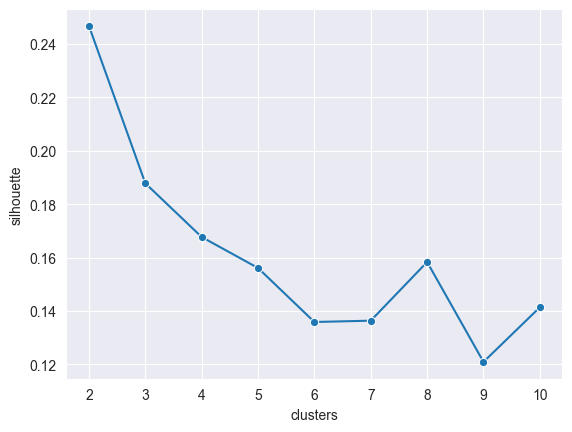

In [5]:
# Silhouette Method

def get_silhouette_kmeans(cluster_num, data_for_KM):
    k_means = cluster.KMeans(n_clusters = cluster_num, n_init = 'auto', random_state = 42)
    k_means.fit(data_for_KM)
    silhouette = metrics.silhouette_score(data_for_KM, k_means.predict(data_for_KM))
    return silhouette

results_kmeans = {'silhouette' : [],
                 'clusters' : []}

for cluster_num in range(2, 11):
    results_kmeans['silhouette'].append(get_silhouette_kmeans(cluster_num, X_preprocessed))
    results_kmeans['clusters'].append(cluster_num)

plot_df_kmeans = pd.DataFrame(results_kmeans)

sns.set_style('darkgrid')
sns.lineplot(x = plot_df_kmeans['clusters'], y = plot_df_kmeans['silhouette'], marker = 'o');

print('Max silhouette: {}'.format(round(max(results_kmeans['silhouette']), 2)))

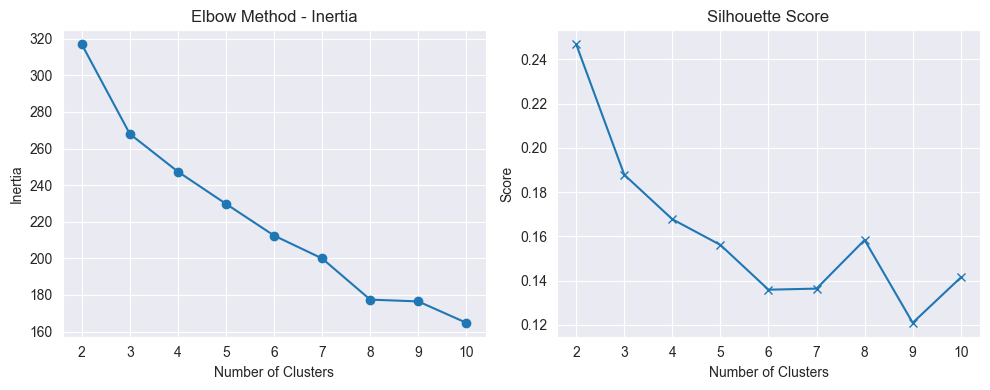

In [6]:
# Elbow and Silhouette methods using Pipeline

inertias = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    pipeline = Pipeline(steps = [
        ('preprocessing', preprocessor),
        ('KMeans', cluster.KMeans(n_clusters = k, random_state = 42, n_init = 'auto'))
    ])
    pipeline.fit(data_for_KM)

    # get cluster labels
    labels = pipeline.named_steps['KMeans'].labels_

    # transform data seperately to calculate silhouette score
    X_processed = pipeline.named_steps['preprocessing'].transform(data_for_KM)

    inertias.append(pipeline.named_steps['KMeans'].inertia_)
    silhouette_scores.append(metrics.silhouette_score(X_preprocessed, labels))

# Visualization

plt.figure(figsize = (10, 4))

plt.subplot(1, 2, 1)
plt.plot(K, inertias, marker = 'o')
plt.title('Elbow Method - Inertia')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, marker = 'x')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.tight_layout()
plt.show();

**Inertia** = The **sum of squared distances** between each data point and the **centroid of its assigned cluster**.

#### Purpose of Inertia
1. Evaluates Cluster Compactness:
   - Lower inertia means the data points are closer to their centroids, i.e., the clusters are tight and dense.
   - Higher inertia means points are more spread out within clusters.

2. Helps Choose Optimal Number of Clusters (k):
   - As you increase k, inertia always decreases.
   - You look for the “elbow point” — where the rate of decrease sharply slows — to find the best balance between model simplicity and accuracy.

In [7]:
# Final Clustering with optimal number of clusters

optimal_k = 2

final_pipeline = Pipeline(steps = [
    ('preprocessing', preprocessor),
    ('Kmeans', cluster.KMeans(n_clusters = optimal_k, random_state = 42, n_init = 'auto'))
])

data_for_KM['Cluster_Label'] = final_pipeline.fit_predict(data_for_KM)

print(data_for_KM[['Cluster_Label']].value_counts())
print('\n')
data_for_KM.head()

Cluster_Label
1                36
0                24
Name: count, dtype: int64




,Sector,CEO_Gender,Size,Security_Invest,Security_Breach_Att,Succ_Sec_Breaches,Sec_Rating,CEO_Sec_Exp,LOT_in_Business,Stock_Market,Cluster_Label
0,Banking,Female,Small,17,11,2,Medium,High,13,No,0
1,Banking,Male,Small,18,12,4,High,Low,9,No,0
2,Banking,Male,Small,17,12,4,High,Medium,22,No,0
3,Banking,Male,Small,24,13,1,High,Medium,3,Yes,0
4,Banking,Male,Small,32,14,3,High,Medium,4,Yes,0


### Conclusion:

The Silhouette Score measures how well each data point fitsd within its assigned cluster = it balances cohesion(how close) and separation(how distinct). Max silhoutte was calculated as 0.25, which is on the boarder between and poor. It suggests that clusters are not very distinct and may overlap. This could be due to:
* too few clusters;
* unnatural groupings (K-Means imposes spherical clusters)

It is worth to try different algorithm. 

**Principal Component Analysis (PCA)** is a statistical technique that **transforms a dataset with many features into a smaller set of uncorrelated components**, while **retaining as much variance (information)** as possible.

### PCA

In [8]:
data_for_PCA = data.copy()
data_for_PCA.head()

,Sector,CEO_Gender,Size,Security_Invest,Security_Breach_Att,Succ_Sec_Breaches,Sec_Rating,CEO_Sec_Exp,LOT_in_Business,Stock_Market
0,Banking,Female,Small,17,11,2,Medium,High,13,No
1,Banking,Male,Small,18,12,4,High,Low,9,No
2,Banking,Male,Small,17,12,4,High,Medium,22,No
3,Banking,Male,Small,24,13,1,High,Medium,3,Yes
4,Banking,Male,Small,32,14,3,High,Medium,4,Yes


In [9]:
preprocessor = ColumnTransformer(transformers = [
    ('nominal', preprocessing.OneHotEncoder(), nominal_variable),
    ('ordinal', preprocessing.OrdinalEncoder(), ordinal_variable),
    ('scale', preprocessing.StandardScaler(), scale_variable)
])

X_pca_preprocessed = preprocessor.fit_transform(data_for_PCA)

pipeline_pca = Pipeline([
    ('preprocessor', preprocessor),
    ('PCA', decomposition.PCA(n_components = 3))
])

pca = pipeline_pca.fit_transform(data_for_PCA)

pca_components_first = pipeline_pca['PCA'].explained_variance_ratio_[0]

print('The first component explains the proportion of variance: {}'.format(round(pca_components_first, 2)))

The first component explains the proportion of variance: 0.34


### The result:

34% of the total variance in the dataset after preprocessing is captured by the first principal component. 

PCA (Principal Component Analysis) is a dimensionality reduction technique. It transforms the original features into new axes (called principal components) that:
- are uncorrelated (orthogonal)
- capture the maximum variance in the data.

So, instead of working with many original variables (which might be correlated and noisy), PCA builds a few new composite variables that explain most of the data's variability.

PCA has 3 components (n_components = 3). PCA ranks these components by how much of the original data's spread (variance) they capture:
- Component 1: 34% variance explained -> It captures the most important pattern in the data
- Component 2: will capture the second most important variance (orthogonal to the first)
- Component 3: will capture the next most variance, and so on.

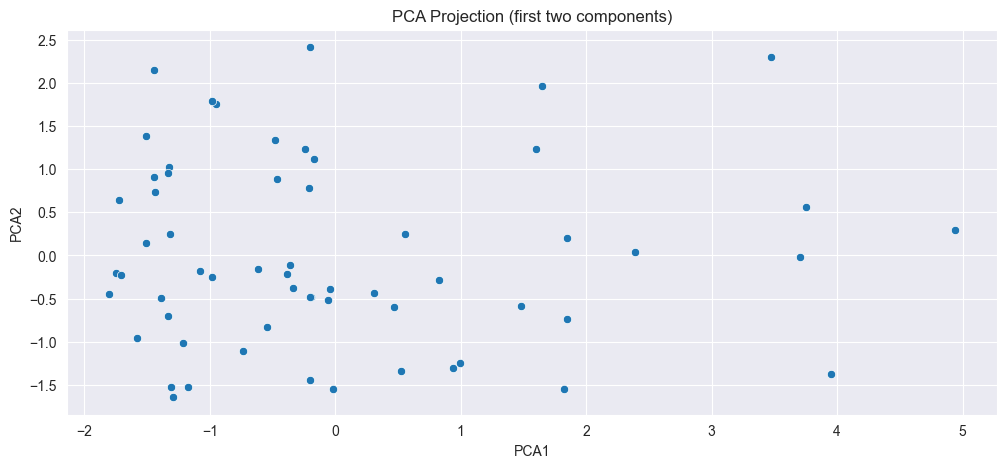

In [10]:
# Visualization

pca = pd.DataFrame(pca, index = data_for_PCA.index)
pca.columns = ['PCA1', 'PCA2', 'PCA3']

fig = plt.figure(figsize = (12, 5))
sns.scatterplot(x = 'PCA1', y = 'PCA2', data = pca, palette = 'Set3')
plt.title('PCA Projection (first two components)');

### Conclusion:

There are some spread, but not clearly seperated clusters. PCA does not cluster - it spreads data along axes of highest variance, not based on group membership. So while PCA simplifies the data, it doesn't tell directly how many clusters there are or what they mean.

Hence, running K-Means on PCA-reduced data is a common and effective approach:
- Noise is reduced (fewer features, only most informative kept)
- Speed improved
- Risk of overfitting is reduced
- Can reveal cleaner clusters than on high-dimentional data

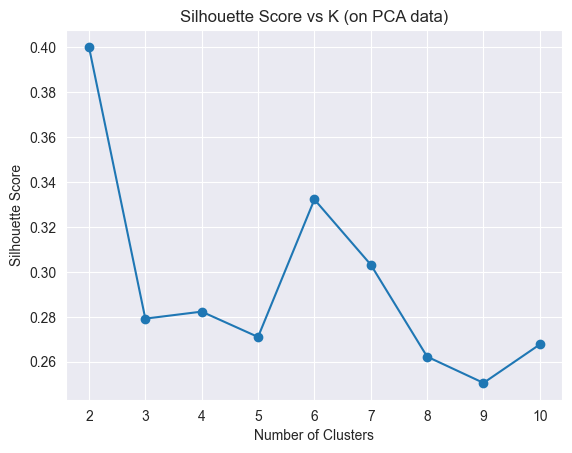


Optimal Number of Clusters: 2




,PCA1,PCA2,PCA3,Cluster_Label
10,1.644879,1.966794,0.821664,1
33,-0.546789,-0.826933,0.929244,0
24,-1.334490,-0.705985,-0.422529,0
39,0.557614,0.243102,-0.109479,0
43,-1.803769,-0.442793,-1.320220,0
32,3.749933,0.561376,0.488709,1
40,-0.171806,1.122534,0.454178,0
41,0.308825,-0.432995,-0.701178,0
25,-1.449239,0.911427,0.393622,0
3,-1.294309,-1.645129,1.286167,0


In [11]:
silhouttes = []

# Select k in the range between 2 and 10
for k in range(2, 11):
    kmeans = cluster.KMeans(n_clusters = k, random_state = 42, n_init = 'auto')
    labels = kmeans.fit_predict(pca)
    score = metrics.silhouette_score(pca, labels)
    silhouttes.append((k, score))

# Visualization
k_vals, sil_vals = zip(*silhouttes)
plt.plot(k_vals, sil_vals, marker = 'o')
plt.title('Silhouette Score vs K (on PCA data)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show();

# Choose the best number of clusters
best_k = max(silhouttes, key = lambda x: x[1])[0]
print('\nOptimal Number of Clusters:', best_k)
print('\n')

# Final Model
kmeans_final = cluster.KMeans(n_clusters = best_k, random_state = 42, n_init = 'auto')
final_labels = kmeans_final.fit_predict(pca)

pca['Cluster_Label'] = final_labels
pca.sample(10)

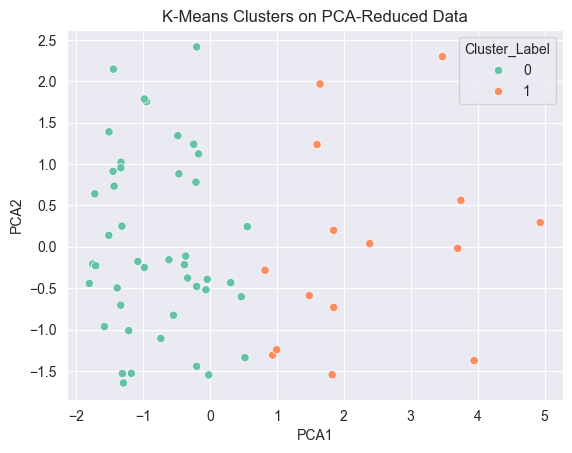

In [12]:
# Visualization

sns.scatterplot(x = 'PCA1', y = 'PCA2', hue = 'Cluster_Label',  data = pca, palette = 'Set2')
plt.title('K-Means Clusters on PCA-Reduced Data')
plt.show();

### Conclusion:

The silhouette score improved significantly from 0.25 of K-Means on the raw data vs 0.40 after applying PCA. This suggests that PCA denoised the data and highlighted the main structure, making clusters more distinguishable. That shows that the data has a stronger natural grouping after dimensionality reduction - likely because PCA filtered out irrelevant or noisy variation. Both before and after PCA, the best silhouette score occures at number of clusters equals 2. This is a strong indication that the dataset naturally seperates into two distinct groups. The plot above shows that it is possible to have split the data into 6 clusters, although the silhouette score is only 0.33 and it is possible that splitting the data into 6 clusters will lead to overlapping the clusters, it is still worth to try and see the results.

### KNN

#### 1. Transfer K-Means cluster labels (from PCA data) to Original Dataset 

In [13]:
# 1. Run KMeans with number of clusters -> 2

kmeans_2 = cluster.KMeans(n_clusters = 2, random_state = 42, n_init = 'auto')
cluster_labels_2 = kmeans_2.fit_predict(pca[['PCA1', 'PCA2', 'PCA3']])

# 2. Run KMeans with number of clusters -> 6

kmeans_6 = cluster.KMeans(n_clusters = 6, random_state = 42, n_init = 'auto')
cluster_labels_6 = kmeans_6.fit_predict(pca[['PCA1', 'PCA2', 'PCA3']])

# 3. Add both cluster assignments to the PCA Dataframe

pca['Cluster_2'] = cluster_labels_2
pca['Cluster_6'] = cluster_labels_6

data_for_PCA['Cluster_2'] = pca['Cluster_2'].values
data_for_PCA['Cluster_6'] = pca['Cluster_6'].values

data_for_PCA.head()

,Sector,CEO_Gender,Size,Security_Invest,Security_Breach_Att,Succ_Sec_Breaches,Sec_Rating,CEO_Sec_Exp,LOT_in_Business,Stock_Market,Cluster_2,Cluster_6
0,Banking,Female,Small,17,11,2,Medium,High,13,No,0,0
1,Banking,Male,Small,18,12,4,High,Low,9,No,0,5
2,Banking,Male,Small,17,12,4,High,Medium,22,No,0,0
3,Banking,Male,Small,24,13,1,High,Medium,3,Yes,0,5
4,Banking,Male,Small,32,14,3,High,Medium,4,Yes,0,5


In [14]:
# Preprocessing original data

nominal_variable = ['Sector', 'Stock_Market', 'CEO_Gender']
ordinal_variable = ['Size', 'Sec_Rating', 'CEO_Sec_Exp']
scale_variable = ['Security_Breach_Att', 'Security_Invest', 'Succ_Sec_Breaches', 'LOT_in_Business']

preprocessor = ColumnTransformer(transformers = [
    ('nominal', preprocessing.OneHotEncoder(), nominal_variable),
    ('ordinal', preprocessing.OrdinalEncoder(), ordinal_variable),
    ('scale', preprocessing.StandardScaler(), scale_variable)
])

df_preprocessed = preprocessor.fit_transform(data)
column_names = preprocessor.get_feature_names_out()

df = pd.DataFrame(df_preprocessed, columns = column_names)
df.head()

,nominal__Sector_Banking,nominal__Sector_Health Care,nominal__Sector_Hospitality,nominal__Stock_Market_No,nominal__Stock_Market_Yes,nominal__CEO_Gender_Female,nominal__CEO_Gender_Male,ordinal__Size,ordinal__Sec_Rating,ordinal__CEO_Sec_Exp,scale__Security_Breach_Att,scale__Security_Invest,scale__Succ_Sec_Breaches,scale__LOT_in_Business
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0,-0.676184,-0.676729,-0.887836,0.714338
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,-0.660501,-0.662181,-0.801778,0.064940
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,2.0,-0.660501,-0.676729,-0.801778,2.175485
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,2.0,-0.644819,-0.574892,-0.930865,-0.909158
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,2.0,-0.629136,-0.458507,-0.844807,-0.746808


In [15]:
df['Cluster_2'] = pca['Cluster_2'].values
df['Cluster_6'] = pca['Cluster_6'].values

df.head()

,nominal__Sector_Banking,nominal__Sector_Health Care,nominal__Sector_Hospitality,nominal__Stock_Market_No,nominal__Stock_Market_Yes,nominal__CEO_Gender_Female,nominal__CEO_Gender_Male,ordinal__Size,ordinal__Sec_Rating,ordinal__CEO_Sec_Exp,scale__Security_Breach_Att,scale__Security_Invest,scale__Succ_Sec_Breaches,scale__LOT_in_Business,Cluster_2,Cluster_6
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,2.0,0.0,-0.676184,-0.676729,-0.887836,0.714338,0,0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,1.0,-0.660501,-0.662181,-0.801778,0.064940,0,5
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,2.0,-0.660501,-0.676729,-0.801778,2.175485,0,0
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,2.0,-0.644819,-0.574892,-0.930865,-0.909158,0,5
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,2.0,-0.629136,-0.458507,-0.844807,-0.746808,0,5


#### 2. KNN Classifier for two clusters

In [16]:
X_2 = df.drop(columns = ['Cluster_2', 'Cluster_6'], axis = 1)
y_2 = df['Cluster_2']

X_train_2, X_test_2, y_train_2, y_test_2 = model_selection.train_test_split(X_2, y_2, test_size = 0.2, random_state = 42)

knn_2 = KNeighborsClassifier(n_neighbors = 3)
knn_2.fit(X_train_2, y_train_2)

y_pred_2 = knn_2.predict(X_test_2)

print('KNN Classifier Report for TWO Clusters \n')
print(metrics.classification_report(y_test_2, y_pred_2))

KNN Classifier Report for TWO Clusters 

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.50      1.00      0.67         1

    accuracy                           0.92        12
   macro avg       0.75      0.95      0.81        12
weighted avg       0.96      0.92      0.93        12



#### 3. KNN Classifier for six clusters

In [17]:
X_6 = df.drop(columns = ['Cluster_2', 'Cluster_6'], axis = 1)
y_6 = df['Cluster_6']

X_train_6, X_test_6, y_train_6, y_test_6 = model_selection.train_test_split(X_6, y_6, test_size = 0.2, random_state = 42)

knn_6 = KNeighborsClassifier(n_neighbors = 3)
knn_6.fit(X_train_6, y_train_6)

y_pred_6 = knn_2.predict(X_test_6)

print('KNN Classifier Report for SIX Clusters \n')
print(metrics.classification_report(y_test_6, y_pred_6))

KNN Classifier Report for SIX Clusters 

              precision    recall  f1-score   support

           0       0.10      1.00      0.18         1
           1       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         7
           5       0.00      0.00      0.00         3

    accuracy                           0.17        12
   macro avg       0.15      0.50      0.21        12
weighted avg       0.05      0.17      0.07        12



### Conclusion:

Model with 2 clusters shows high performance overall. Slight impalance in test data, but both classes were predicted. Model captures both clusters reasonably well.

Model with 6 clusters on the contrary failing to classify most classes.

KMeans silhouette score also favored 2 clustes split.

Therefore, for further analysis 2 clusters split data will be used.

#### 4. Tune parameter (n_neighbors) using loop

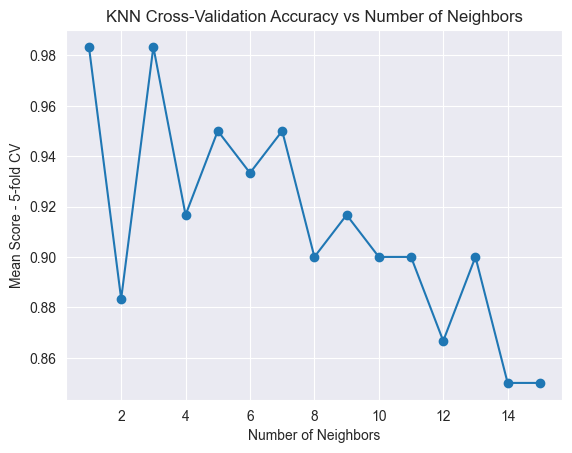

Best n_neighbors on cross-validation: 1


In [18]:
k_values = range(1, 16)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k)
    scores = model_selection.cross_val_score(knn, X_2, y_2, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

plt.plot(k_values, cv_scores, marker = 'o')
plt.title('KNN Cross-Validation Accuracy vs Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Mean Score - 5-fold CV')
plt.show();

best_k = k_values[cv_scores.index(max(cv_scores))]
print(f'Best n_neighbors on cross-validation: {best_k}')

In [19]:
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train_2, y_train_2)

y_pred = knn.predict(X_test_2)

print('KNN Classifier Report \n')
print(metrics.classification_report(y_test_2, y_pred))

KNN Classifier Report 

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.50      1.00      0.67         1

    accuracy                           0.92        12
   macro avg       0.75      0.95      0.81        12
weighted avg       0.96      0.92      0.93        12



#### 5. Tune hyperparameters with GridSearchCV

In [20]:
param_grid = {
    'n_neighbors' : list(range(1, 11)),
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan']
}

grid_search = model_selection.GridSearchCV(
    estimator = KNeighborsClassifier(),
    param_grid = param_grid,
    cv = 5,
    scoring = 'f1_weighted',
    n_jobs = -1,
    verbose = 1
)

grid_search.fit(X_train_2, y_train_2)

print('Best Hyperparameters: ')
print(grid_search.best_params_)

best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_2)

print('\n Classification Report on Test Set - Best Model: ')
print(metrics.classification_report(y_test_2, y_pred_best))

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Hyperparameters: 
{'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}

 Classification Report on Test Set - Best Model: 
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.50      1.00      0.67         1

    accuracy                           0.92        12
   macro avg       0.75      0.95      0.81        12
weighted avg       0.96      0.92      0.93        12



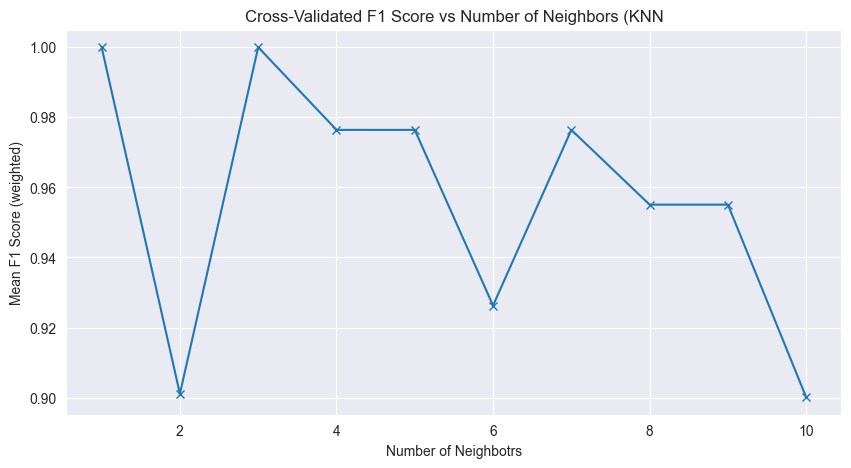

In [21]:
# Visualization

cv_results = pd.DataFrame(grid_search.cv_results_)

filtered = cv_results[(cv_results['param_weights'] == 'uniform') & (cv_results['param_metric'] == 'euclidean')]

plt.figure(figsize = (10, 5))
plt.plot(filtered['param_n_neighbors'], filtered['mean_test_score'], marker = 'x')
plt.title('Cross-Validated F1 Score vs Number of Neighbors (KNN')
plt.xlabel('Number of Neighbotrs')
plt.ylabel('Mean F1 Score (weighted)')
plt.grid(True)
plt.show();

### Conclusion:

There are two peaks on the plot: n_neighbors = 1 and n_neighbors = 3. The above calculation has shown the same results. Both given the near-prefect F1 score (~ 1.00). Model with n_neighbors = 1 might be overfitting, since it is highly sensitive to noise and class imbalance. Model with n_neighbors = 3 is likely a better balance of flexibility and generalization. 

### Confusion Matrix

<Figure size 500x400 with 0 Axes>

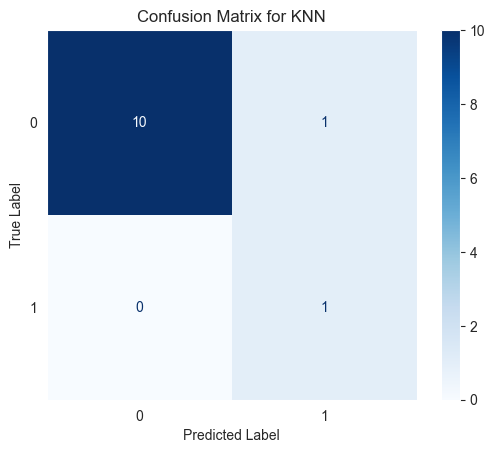

In [22]:
best_knn = KNeighborsClassifier(n_neighbors = 3).fit(X_train_2, y_train_2)
y_pred_2 = best_knn.predict(X_test_2)

# Compute confusion matrix
cm = metrics.confusion_matrix(y_test_2, y_pred_2)

# Display confusion matrix
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = best_knn.classes_)

# Visualization
plt.figure(figsize = (5, 4))
disp.plot(cmap = 'Blues', values_format = 'd')
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)
plt.show();

## Part II: KNN Regressor

In [23]:
data.head()

,Sector,CEO_Gender,Size,Security_Invest,Security_Breach_Att,Succ_Sec_Breaches,Sec_Rating,CEO_Sec_Exp,LOT_in_Business,Stock_Market
0,Banking,Female,Small,17,11,2,Medium,High,13,No
1,Banking,Male,Small,18,12,4,High,Low,9,No
2,Banking,Male,Small,17,12,4,High,Medium,22,No
3,Banking,Male,Small,24,13,1,High,Medium,3,Yes
4,Banking,Male,Small,32,14,3,High,Medium,4,Yes


In [24]:
def print_metrics(y_train, y_train_pred, y_test, y_test_pred):

    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_pred)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_pred)))
    print('Train RMSE: {:.3f}'.format(metrics.root_mean_squared_error(y_train, y_train_pred)))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_pred)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_pred)))
    print('Test RMSE: {:.3f}'.format(metrics.root_mean_squared_error(y_test, y_test_pred)))

In [25]:
# Target feature - Number of Successful Breach Attemps

X = data.drop(columns = ['Succ_Sec_Breaches'], axis = 1)
y = data['Succ_Sec_Breaches']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 42)

# Data Preprocessing

preprocessor = ColumnTransformer([
    ('nominal', preprocessing.OneHotEncoder(), ['Sector', 'Stock_Market', 'CEO_Gender']),
    ('ordinal', preprocessing.OrdinalEncoder(), ['Size', 'Sec_Rating', 'CEO_Sec_Exp']),
    ('scale', preprocessing.StandardScaler(), ['Security_Invest', 'Security_Breach_Att', 'LOT_in_Business'])
])

# Initial Model Run

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('KNN', KNeighborsRegressor(n_neighbors = 5))
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.866
Train MAE: 6.983
Train RMSE: 8.817


Test R^2: 0.665
Test MAE: 8.467
Test RMSE: 10.644


In [26]:
# GridSearchCV to fine and tune hyperparameters

pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('KNN', KNeighborsRegressor())
])

param_grid = {'KNN__n_neighbors':list(range(1, 11))}

grid = model_selection.GridSearchCV(pipeline, param_grid = param_grid,
                                   cv = 5, scoring = 'neg_root_mean_squared_error')
grid.fit(X_train, y_train)

print(f"Best n_neighbors: {grid.best_params_['KNN__n_neighbors']}")
print(f'Best RMSE: {-grid.best_score_:.2f}')
print('\n')

y_train_pred = grid.predict(X_train)
y_test_pred = grid.predict(X_test)

#print(f'Test RMSE: {metrics.mean_squared_error(y_test, y_pred, squared = False):.2f}')
#print(f'Test R2 Score: {metrics.r2_score(y_test, y_pred):.2f}')

print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Best n_neighbors: 2
Best RMSE: 10.83


Train R^2: 0.926
Train MAE: 4.427
Train RMSE: 6.541


Test R^2: 0.655
Test MAE: 7.708
Test RMSE: 10.793


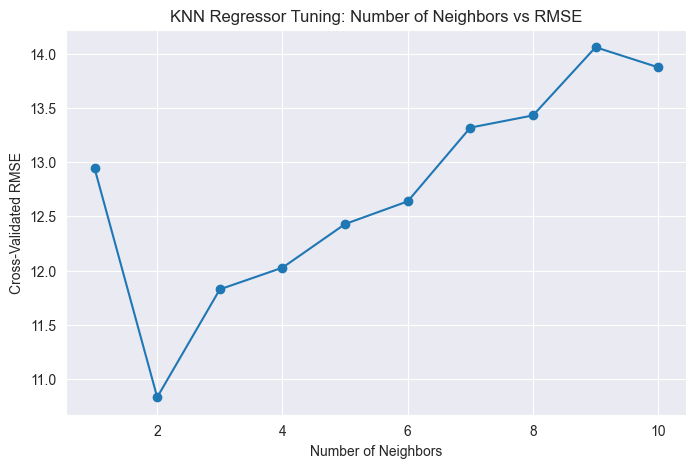

In [27]:
# Visualization

rmse_scores = -grid.cv_results_['mean_test_score']
k_values = param_grid['KNN__n_neighbors']

plt.figure(figsize = (8, 5))
plt.plot(k_values, rmse_scores, marker = 'o')
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-Validated RMSE')
plt.title('KNN Regressor Tuning: Number of Neighbors vs RMSE')
plt.grid(True)
plt.show();

### Conclusion:

**Observations**:
1. Lowest RMSE is at k = 2:
    - RMSE ~ 10.8 (lowesr point)
    - This suggests that the model performs best (in terms of error) with 2 neighbors
2. RMSE increases steadily as k increases from 2 to 10:
   - At higher k values (especially 9 and 10), RMSE rises to ~ 14.0
   - This means predictions get less accurate as more neighbors are averaged
3. k = 1 also perfroms worse than k = 2:
   - Although k = 1 is relatively low, it overfits slightly compare to k = 2.

**Interpretation**

- Low k (1-2): The model is very flexible, adapting closely to the training data. This can lead to low bias but high variance. However, in this case, k = 2 hits the sweet spot.
- Higher k (3-10): The model becomes smoother, averaging over more neighbors. This increase bias and reduces variance, but in this case, it results in higher RMSE - so we are underfitting

**Conclusions**
1. Optimal number of neighbors is k = 2, based on the lowest cross-validated RMSE.
2. Using more neighbors worsens the model's predictive accuracy, as the RMSE increases steadily with higher k.
3. There is a trade-off:
   - Too few neighbors -> risk of overfitting
   - Too many neighbors -> risk of underfitting
   - Here k = 2 appears to offer the best balance for the dataset.
4. Model should be trained using k = 2 for the deployment.

### Permutation Importance

Permutation Importance measures a feature's impact on model performance by:
1. Randomly shuffling one feature at a time,
2. Measuring how much the model's performance drops
3. The more the drop, the more important the feature is

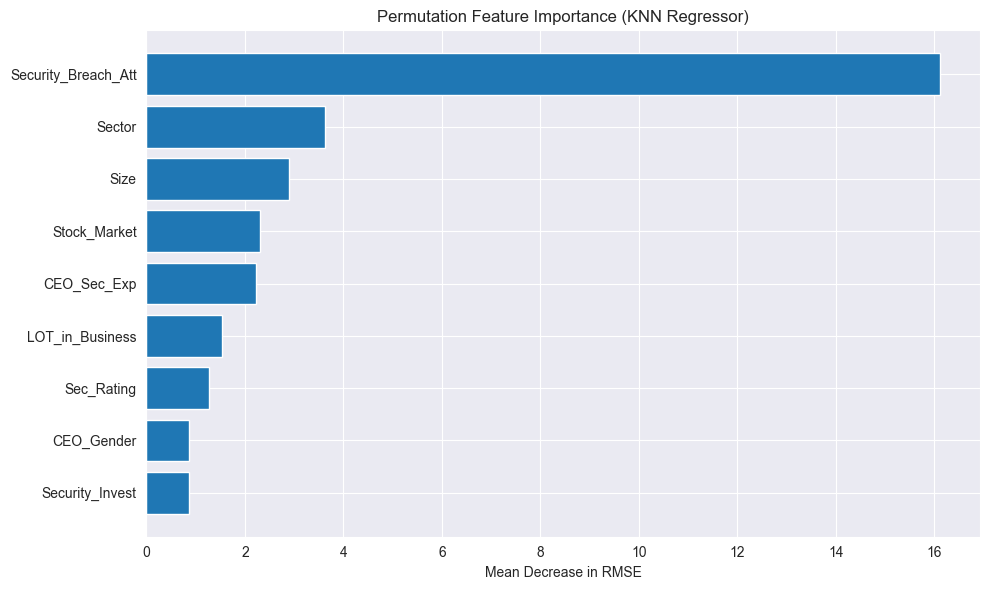

In [28]:
from sklearn.inspection import permutation_importance

# Best Model
pipeline_final = Pipeline([
    ('preprocess', preprocessor),
    ('KNN', KNeighborsRegressor(n_neighbors = 2))
])

pipeline_final.fit(X_train, y_train)

# Compute permutation importance
result = permutation_importance(pipeline_final, X_test, y_test,
                               scoring = 'neg_root_mean_squared_error',
                               n_repeats = 10,
                               random_state = 42)

# Convert to DataFrame for plotting
importance_df = pd.DataFrame({
    'Feature' : X.columns,
    'Importance' : result.importances_mean
}).sort_values(by = 'Importance', ascending = False)

# Plot
plt.figure(figsize = (10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Mean Decrease in RMSE')
plt.title('Permutation Feature Importance (KNN Regressor)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show();

## Part III KNN Classifier

In [29]:
# Define features and target

X = data.drop('Sec_Rating', axis = 1)
y = data['Sec_Rating']

# Deafine features by type

ordinal_variable = ['Size', 'CEO_Sec_Exp']
nominal_variable = ['Sector', 'Stock_Market', 'CEO_Gender']
numeric_variable = ['Security_Invest', 'Security_Breach_Att', 'Succ_Sec_Breaches', 'LOT_in_Business']

# Define ordinal categories (assumed order based on context)

ordinal_categories = [
    ['Small', 'Medium', 'Large'],
    ['Low', 'Medium', 'High']
]

# Target encoding

y = preprocessing.OrdinalEncoder(categories = [['Low', 'Medium', 'High']]).fit_transform(y.values.reshape(-1, 1)).ravel()

# Preprocessing pipeline

preprocessor = ColumnTransformer(transformers = [
    ('ordinal', preprocessing.OrdinalEncoder(categories = ordinal_categories), ordinal_variable),
    ('nominal', preprocessing.OneHotEncoder(), nominal_variable),
    ('numeric', preprocessing.StandardScaler(), numeric_variable)
])

# Model

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors = 1))
])

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 42)

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

print('Train: ', metrics.classification_report(y_train, y_train_pred, target_names = ['Low', 'Medium', 'High']))
print('Test: ', metrics.classification_report(y_test, y_test_pred, target_names = ['Low', 'Medium', 'High']))

Train:                precision    recall  f1-score   support

         Low       1.00      1.00      1.00        16
      Medium       1.00      1.00      1.00        17
        High       1.00      1.00      1.00        15

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48

Test:                precision    recall  f1-score   support

         Low       0.00      0.00      0.00         1
      Medium       0.25      0.20      0.22         5
        High       0.33      0.17      0.22         6

    accuracy                           0.17        12
   macro avg       0.19      0.12      0.15        12
weighted avg       0.27      0.17      0.20        12



### Conclusion:

Model performs very poorly on the test set.

1. Overfitting is the main issue
   - the model memorizes the training data
   - it generalizes poorly to unseen test data
   - typical of KNN with small datasets
2. Very small Test Set
   - only 12 test samples
   - performance metrics are unstable with such small class size
   - One wrong prediction drastically lowers scores

Possible ways to improve the results:
- apply class rebalancing techniques (SMOTE)
- fine and tune hyperparameters with GridSearchCV

In [30]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [31]:
from imblearn.pipeline import Pipeline

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state = 42)),
    ('classifier', KNeighborsClassifier())
])

# Split the dataset with stratification

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 42)

param_grid = {
    'classifier__n_neighbors' : list(range(1, 5)),
    'classifier__weights' : ['uniform', 'distance'],
    'classifier__metric' : ['euclidean', 'manhattan']
}

grid = model_selection.GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'f1_macro')
grid.fit(X_train, y_train)

y_train_pred = grid.predict(X_train)
y_test_pred = grid.predict(X_test)

print('\nBest Parameters: ', grid.best_params_)
print('\nClassification Report on Train set:\n', metrics.classification_report(y_train, y_train_pred))
print('\nClassification Report on Test set:\n', metrics.classification_report(y_test, y_test_pred))
print('Confusion Matrix:\n', metrics.confusion_matrix(y_test, y_test_pred))


Best Parameters:  {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 3, 'classifier__weights': 'uniform'}

Classification Report on Train set:
               precision    recall  f1-score   support

         0.0       0.63      0.86      0.73        14
         1.0       0.79      0.65      0.71        17
         2.0       0.87      0.76      0.81        17

    accuracy                           0.75        48
   macro avg       0.76      0.76      0.75        48
weighted avg       0.77      0.75      0.75        48


Classification Report on Test set:
               precision    recall  f1-score   support

         0.0       0.29      0.67      0.40         3
         1.0       0.33      0.20      0.25         5
         2.0       0.00      0.00      0.00         4

    accuracy                           0.25        12
   macro avg       0.21      0.29      0.22        12
weighted avg       0.21      0.25      0.20        12

Confusion Matrix:
 [[2 1 0]
 [2 1 2]
 [3 1 0

In [32]:
# Cross-Validation

scores = model_selection.cross_val_score(grid.best_estimator_, X, y, cv = 5, scoring = 'f1_macro')
print('Cross-validated F1 scores: {:.3f}'.format(scores.mean()))

Cross-validated F1 scores: 0.329


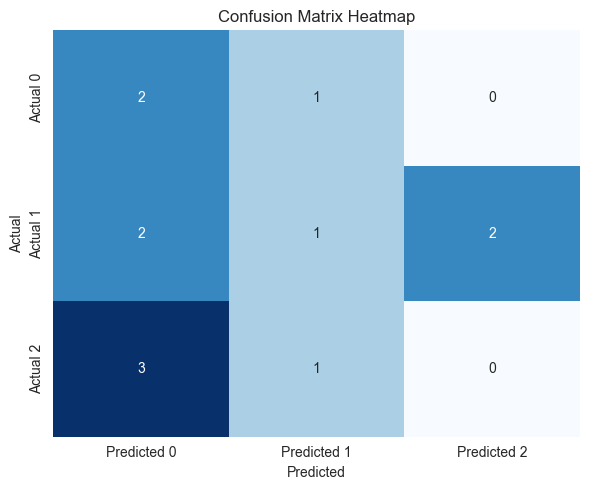

In [33]:
# Visualization

conf_matrix = metrics.confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2'],
            yticklabels=['Actual 0', 'Actual 1', 'Actual 2'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show();

🔹 Class 0:
- 2 correct predictions
- 1 misclassified as class 1
- Model recognizes class 0 fairly well

🔹 Class 1:
- 1 correct
- 2 misclassified as class 0
- 2 correctly classified as class 2

→ This suggests class 1 is being confused with both class 0 and class 2, likely due to overlapping feature patterns

🔹 Class 2:
- 3 misclassified as class 0
- 1 as class 1
- 0 correct predictions

→ Class 2 is still poorly modeled, likely due to insufficient distinguishing patterns or under-representation in training data